In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 94% 140M/149M [00:01<00:00, 114MB/s]
100% 149M/149M [00:01<00:00, 114MB/s]


In [3]:
def get_class_paths(path):
  classes = []
  class_paths = []

  # Iterate through directories in the training path
  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    # Check if it's a directory
    if os.path.isdir(label_path):
      # Iterate through images in the label directory
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)

        # Add class and path to respective lists
        classes.append(label)
        class_paths.append(image_path)

  # Create a DataFrame with the collected data
  df = pd.DataFrame({
      'Class Path': class_paths,
      'Class': classes
  })

  return df

In [4]:
tr_df = get_class_paths("/content/Training")

In [5]:
ts_df = get_class_paths("/content/Testing")

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import regularizers


In [7]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, stratify=ts_df['Class'])

In [8]:
# Standardize Image Size and Brightness to improve consistency.
batch_size = 32

img_size = (299, 299)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

In [9]:
# Standardize Image Size and Brightness to improve consistency.
batch_size = 16

img_size = (224, 224)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


# Takes Traning DF and creates flow of images from DF
tr_gen = image_generator.flow_from_dataframe(
    tr_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size
)

# Keeping order of Testing Data consistent
ts_gen = ts_gen.flow_from_dataframe(
    ts_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=16,
    target_size=img_size,
    shuffle=False
)

valid_gen = image_generator.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size
)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


In [10]:
# Create model
cnn_model = Sequential()

# First Convolutional Block
cnn_model.add(Conv2D(512, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(512, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.10))


# Second Convolutional Block
cnn_model.add(Conv2D(256, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.10))

# Third Convolutional Block
cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.10))

cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.10))

# Fourth Convolutional Block
cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
cnn_model.add(Flatten())

# Dense layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(Dropout(0.35))

# Output layer
cnn_model.add(Dense(4, activation='softmax'))

# Compile the model
cnn_model.compile(Adamax(learning_rate = 0.001), loss='categorical_crossentropy', metrics= ['accuracy', Precision(), Recall()])

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Train the model
history = cnn_model.fit(
    tr_gen,
    epochs=25,
    validation_data=valid_gen,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 270s 607ms/step - accuracy: 0.6301 - loss: 4.1954 - precision: 0.6690 - recall: 0.5752 - val_accuracy: 0.2595 - val_loss: 4.6452 - val_precision: 0.2601 - val_recall: 0.2565 - learning_rate: 0.0010
Epoch 2/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 190s 532ms/step - accuracy: 0.8147 - loss: 2.7115 - precision: 0.8363 - recall: 0.7830 - val_accuracy: 0.6733 - val_loss: 2.5004 - val_precision: 0.7234 - val_recall: 0.6550 - learning_rate: 0.0010
Epoch 3/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 202s 533ms/step - accuracy: 0.8442 - loss: 1.9819 - precision: 0.8618 - recall: 0.8225 - val_accuracy: 0.8626 - val_loss: 1.5619 - val_precision: 0.8784 - val_recall: 0.8489 - learning_rate: 0.0010
Epoch 4/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 191s 535ms/step - accuracy: 0.8797 - loss: 1.4542 - precision: 0.8923 - recall: 0.8610 - val_accuracy: 0.8824 - val_loss: 1.1978 - val_precision: 0.8834 - val_recall: 0.8672 - learning_rate: 0.0010
Epoch 5/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 191s 534ms/step - a

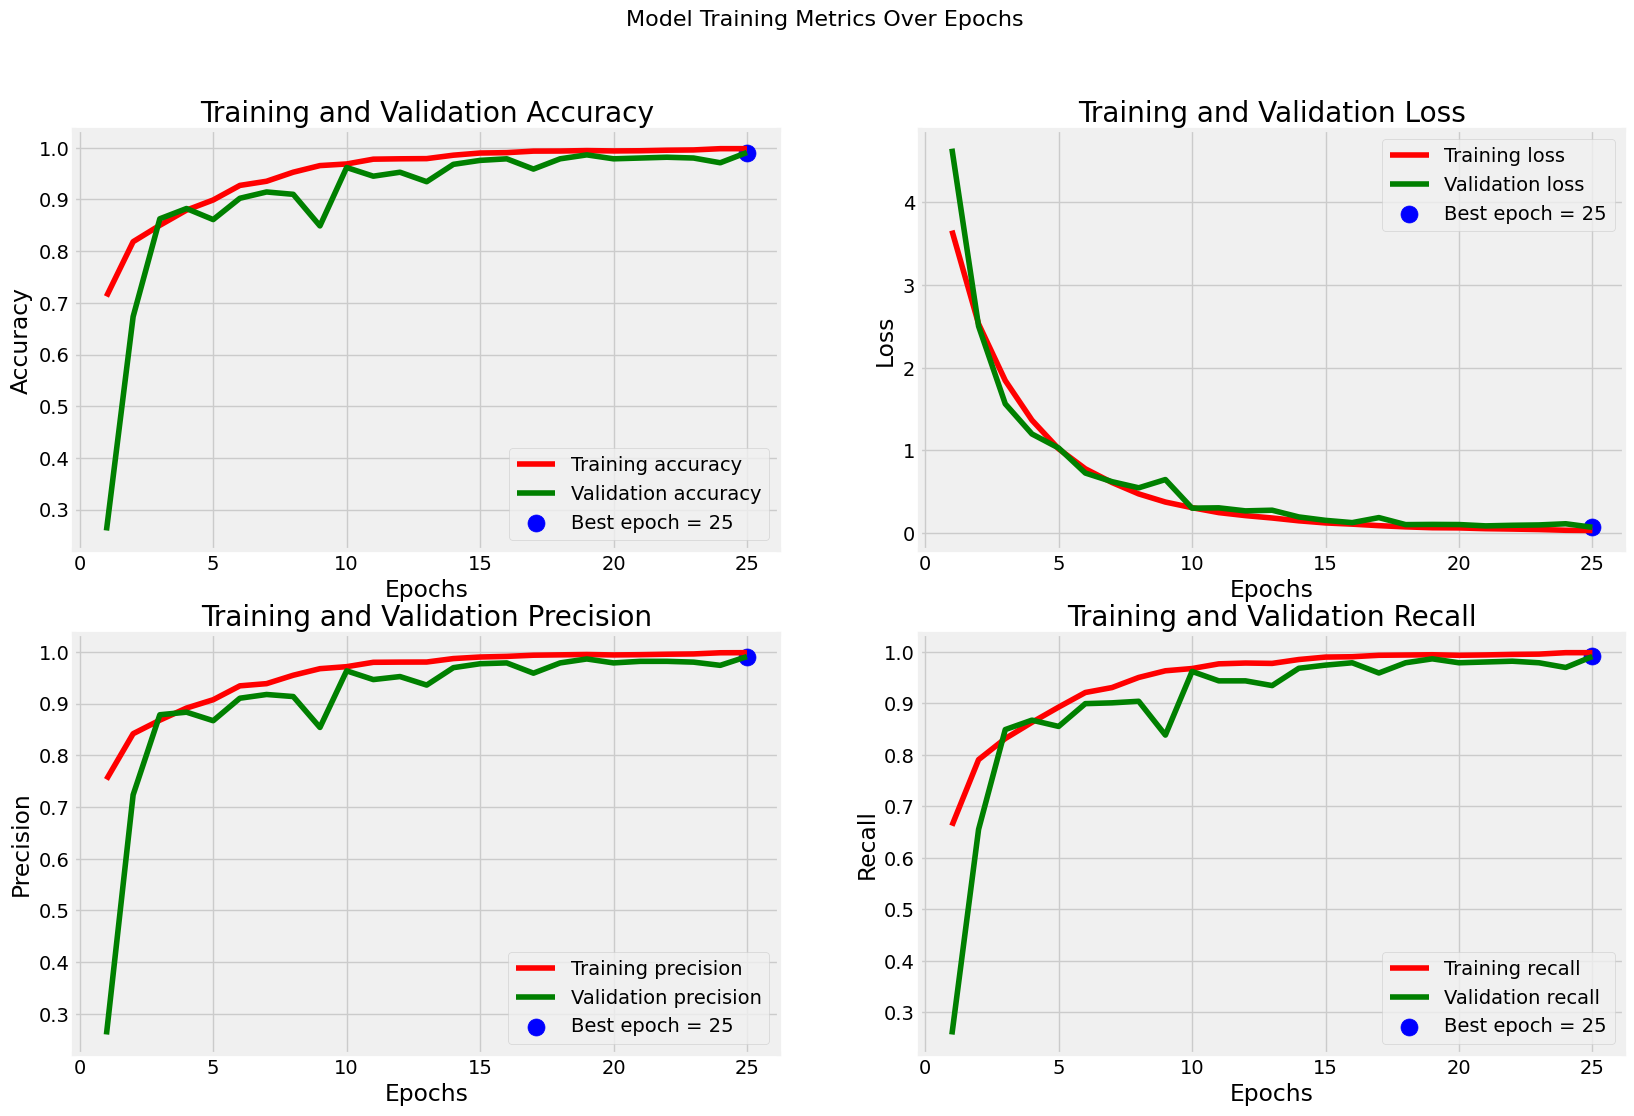

In [12]:
# Getting training and validation metrics from history
metrics = ['accuracy', 'loss', 'precision', 'recall']
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2, 2, i)
  epochs = range(1, len(tr_metrics[metric]) + 1)

  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue',
              label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [17]:
train_score =  cnn_model.evaluate(tr_gen, verbose=1)
valid_score = cnn_model.evaluate(valid_gen, verbose=1)
test_score = cnn_model.evaluate(ts_gen, verbose=1)

print(f'Traning Accuracy: {train_score[1]*100:.2f}%')
print(f'Train Loss: {train_score[0]:.4f}')
print(f'\n\nValidation Accuracy: {valid_score[1]*100:.2f}%')
print(f'Validation Loss: {valid_score[0]:.4f}')
print(f'\n\nTest Accuracy: {test_score[1]*100:.2f}%')
print(f'Test Loss: {test_score[0]:.4f}')

357/357 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 1.0000 - loss: 0.0238 - precision: 1.0000 - recall: 1.0000
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9930 - loss: 0.0644 - precision: 0.9930 - recall: 0.9930
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9804 - loss: 0.1080 - precision: 0.9806 - recall: 0.9804
Traning Accuracy: 100.00%
Train Loss: 0.0239


Validation Accuracy: 99.24%
Validation Loss: 0.0701


Test Accuracy: 98.02%
Test Loss: 0.0885


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step


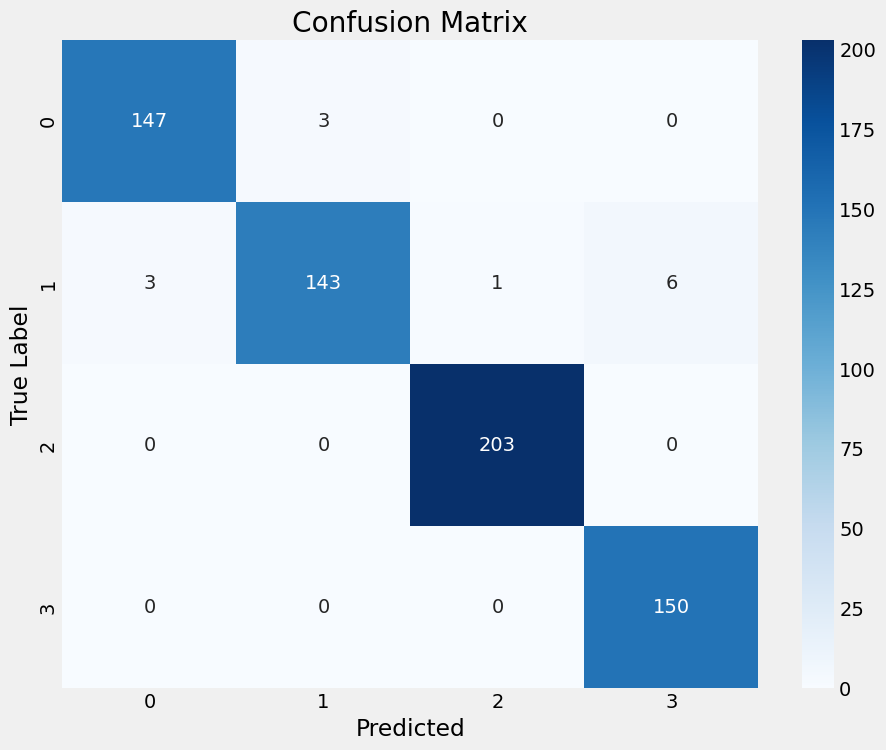

In [18]:
# Confusion Matrix to see where models succeeds and fails
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}

# Then create and display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       150
           1       0.98      0.93      0.96       153
           2       1.00      1.00      1.00       203
           3       0.96      1.00      0.98       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [21]:
cnn_model.save("cnn_model.h5")